In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Preparing data

In [3]:
mnist_dir = "/Users/fineday/Github/data/"

In [4]:
def getDataLoaders(batchsize):
    trainData = datasets.MNIST(root=mnist_dir,
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
    testData = datasets.MNIST(root=mnist_dir,
                              train=False,
                              transform=transforms.ToTensor())
    trainLoader = torch.utils.data.DataLoader(dataset=trainData,
                                              batch_size=batchsize,
                                              shuffle=True)
    testLoader = torch.utils.data.DataLoader(dataset=testData,
                                             batch_size=batchsize,
                                             shuffle=False)
    return trainLoader, testLoader

Defining VAE and loss function

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.f_μ = nn.Linear(400, 20)
        self.f_logσ = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        return self.f_μ(h), self.f_logσ(h)

    def decoder(self, z):
        h = F.relu(self.fc3(z))
        return F.logsigmoid(self.fc4(h))

    def reparameterize(self, μ, logσ):
        σ = torch.exp(logσ)
        ϵ = torch.randn_like(σ)
        return μ + σ * ϵ

    def forward(self, x):
        μ, logσ = self.encoder(x)
        z = self.reparameterize(μ, logσ)
        return self.decoder(z), μ, logσ


def lossF(logit_x̂, x, μ, logσ):
    term1 = F.binary_cross_entropy_with_logits(logit_x̂, x, reduction='sum')
    term2 = -0.5 * torch.sum(1 + 2*logσ - μ.pow(2) - (2*logσ).exp())
    return term1 + term2

In [62]:
def train(model, trainLoader, optimizer, epoch):
    model.train()
    epochLoss = 0
    for x, _ in trainLoader:
        x = x.to(device).view(-1, 784)
        optimizer.zero_grad()
        logit_x̂, μ, logσ = model(x)
        loss = lossF(logit_x̂, x, μ, logσ)
        loss.backward()
        epochLoss += loss.item()
        optimizer.step()
    print("Epoch {}\t Training Loss {}".format(epoch, epochLoss/len(trainLoader.dataset)))

def test(model, testLoader, epoch):
    model.eval()
    epochLoss = 0
    with torch.no_grad():
        for x, _ in testLoader:
            x = x.to(device).view(-1, 784)
            logit_x̂, μ, logσ = model(x)
            loss = lossF(logit_x̂, x, μ, logσ)
            epochLoss += loss.item()
    print("Epoch {}\t Test Loss {}".format(epoch, epochLoss/len(testLoader.dataset)))

Loading and visualizing data

In [ ]:
trainLoader, testLoader = getDataLoaders(128)

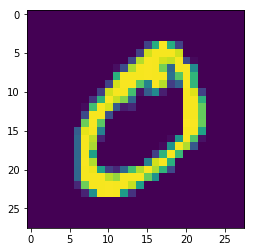

In [19]:
plt.imshow(trainLoader.dataset[1][0].view(28, 28))

In [14]:
print(trainLoader.dataset[1][1])

tensor(0)


Defining model and optimizer

In [64]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters())

Training

In [65]:
for epoch in range(20):
    train(model, trainLoader, optimizer, epoch)
    test(model, testLoader, epoch)

Epoch 0	 Training Loss 175.25303177083333
Epoch 0	 Test Loss 153.68068559570312
Epoch 1	 Training Loss 148.9735180501302
Epoch 1	 Test Loss 145.89324228515625


Drawing $n$ samples $z$ from the latent space and map them to data space to get $x$

In [21]:
n = 10
with torch.no_grad():
    z = torch.randn(n, 20).to(device)
    x = torch.exp(model.decoder(z)).cpu()

x = x.view(n, 28, 28).numpy()

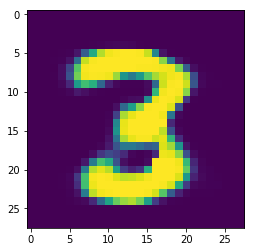

In [24]:
plt.imshow(x[9])